# Building a Shazam clone

This notebook will walk through the steps needed to build a (simple) Shazam clone.  We'll first gather some music files from the Internet Archive.  Alternatively you can use your own library.  We then read and index them to allow for quick searching.

## Downloading from the Internet Archive

We want to download a number of files from the hiphop mixtape collection of the Internet Archive.  This collection is a good starting point as it contains a large variety of music from diverse artists and has enough tracks that we can  tell if we're doing a good job or not.

The webpage for this collection is here:  https://archive.org/details/hiphopmixtapes

Fortunately, the IA provides an API to access it and a Python library has been created to wrap the API already.  This simplifies our work significantly.

In [71]:
import internetarchive as ia
import os
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
# Run this the first time you use the library.  You'll need to register an IA account:
# https://archive.org/account/login.createaccount.php
# ia.configure()

In [52]:
MUSIC_DIR = os.path.expanduser('~/.cache/dl-cookbook/mp3')

def download_collection(max_items):
    count = 0
    archive_session = ia.session.ArchiveSession()
    search = ia.search.Search(archive_session, 'collection:hiphopmixtapes')
    for r in search.iter_as_items():
        kept_files = [
            f for f in r.files
            if (f['name'].endswith('.mp3') and
                float(f['size']) > 1*1000*1000 and
                float(f['size']) < 10*1000*1000)
        ]
        
        if not kept_files:
            continue
        
        r.download(files=[f['name'] for f in kept_files], destdir=MUSIC_DIR)
        count += len([f for f in r.files if f['name'].endswith('.mp3')])
        if count > max_items:
            return
    
os.system('mkdir -p "%s"' % MUSIC_DIR)

# This will take quite a while, and will use a few gigs of disk space.
download_collection(500)

01.IntelligentHoodlum: .......ddddd - success
01.NAOCHOREMEUAMOR: dddddddddddd - success
01.Rebel: ddd - success
01.RoleModel: dddddddd - success
01.YamborghiniHighFt.ASAPRockyASAPFergASAPNastASAPAntASAPTwelvyyJuicyJ: dddddddddd - success
01BandoleroRemix: ddddd - success
01Blink182Lemmings: ddd - success
01Blink182WastingTime: ddddd - success
01BringDaRuckus_201701: dddddddddddd - success
01CanibusItsNoOtherThan: ddddddddddd - success
01CappadonnaSlangEditorial: dddddddddddddd - success
01CassidyFeatJagGunUDown: ddddddddddddddddd - success
01CastYourFateToTheWind: ddddddddddddd - success
01ComingInFromTheCold: dddddddddd - success
01DaveEastTheOfferingProdByBudaGrandz: dddddddddddddd - success
01DementeQueSabenDeMiIntro: ddddddddddddddddd - success
01EstoyContigo: ddddddd - success
01FrankieCutlassRedrumWdk: ddddddddddddd - success
01FuckYouHoe: ddddddddddddddddddddddddddddddd - success
01IAmMadeOfYou: dddddddddddddd - success
01Intro_201611: ddddddddddddddddddd - success
01KillarmyGa

KeyboardInterrupt: 

# Processing our data

Now that we have downloaded all of our music files, we want to build a search index for them.  This means we have to process them in a way that we can look up the right track given a short, noisy snippet of audio.  The authors of Shazam fortunately detail the process they use in this paper.  We will mostly follow the same mechanism:

https://github.com/papers-we-love/papers-we-love/blob/master/audio_comp_sci/shazam-audio-search-algorithm.pdf

## Reading MP3 files

There are a number of programs and libraries available for working with audio files, in this case MP3.  We're going to use librosa; it's easy to install with pip and provides a number of helpful utility functions we can make use of.

In [78]:
import librosa
import librosa.display

SAMPLE_RATE = 4410

reality = librosa.load(
    MUSIC_DIR + '/01.IntelligentHoodlum/02. Back To Reality.mp3',
    sr=SAMPLE_RATE,
    mono=True,
    res_type='kaiser_fast',
    dtype='float32'
)

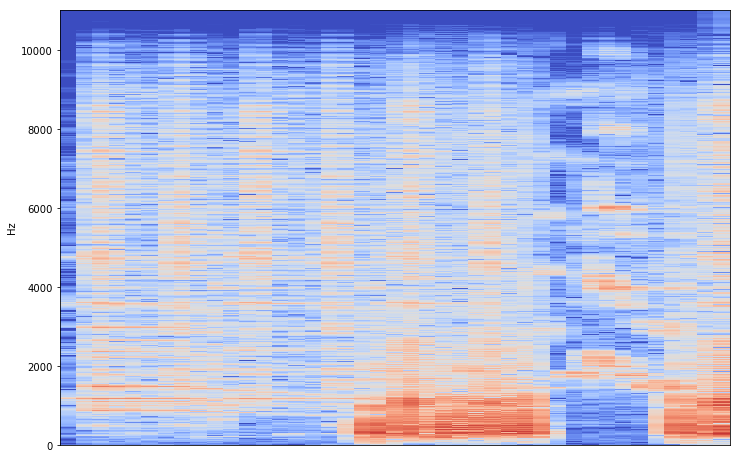

In [85]:
samples = reality[0]
spectrograph = librosa.core.stft(
    samples[:SAMPLE_RATE * 10],
    n_fft=SAMPLE_RATE,
)
D = librosa.amplitude_to_db(spectrograph)

librosa.display.specshow(D, y_axis='linear')